# Optimización de hiperparámetros

**Mediante el método de COBYLA se han optimizado los grafos con un AR < 0.95, se han simulado los 1000 grafos con los parámetros óptimos y se han analizado los resultados.**

In [1]:
from src.ahs_utils import show_register, show_drive_and_local_detuning, show_final_avg_density
from braket.ahs.atom_arrangement import AtomArrangement
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator
from braket.ahs.local_detuning import LocalDetuning

import numpy as np
import numpy.typing as npt

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt
import matplotlib.cm as cm
import seaborn as sns

import networkx as nx

from collections import Counter
import itertools
from tqdm import tqdm
import time

from src.aitor_utils import plot_sp_ar

from ortools.linear_solver import pywraplp

import gurobipy as gp
from gurobipy import GRB

from io import BytesIO
import imageio.v2 as imageio

from scipy import optimize

import qutip as qt

simulator = LocalSimulator("braket_ahs")

In [2]:
## GRAFO
n_seeds = 1000 #100
scale = 5e-6
n_nodos_list = [7]#[10, 11, 12, 13, 14, 15]
# buscamos simular un dropout de 0.4
malla_inicial = {'7': (4,3)}#{'10': (4, 4), '11': (5, 4), '12': (5, 4), '13': (5, 4), '14': (5, 5), '15': (5, 5)}

# SIMULACIÓN
C = 862690 * 2 * np.pi # um^6 * rad / us
blockade_radius=7.1e-6
shots = 20000
steps = 1000

# DRIVINGS
time_max = 4 #us

#--------DRIVINGS FUERTES----------
#Omega_max = 20 *1e6  #RAD/S
#Delta_max =  50 * 1e6 #RAD/S
#Delta_local_max = 1/2*9.9007768e7 #BEST

#--------DRIVINGS SUAVES----------
Omega_max = 20 *1e6  #RAD/S
Delta_max =  50 * 1e6 #RAD/S
Delta_local_max = 9.9007768e7  #* 2/3#BEST con un tercio funciona mejor

Delta_global_0 = (1.0, 0.5) # 0 < a < time_max,    a/2 < b < time_max - a/2
Delta_local_0 = (1.0, 0.5) # 0 < a < time_max,    a/2 < b < time_max - a/2
Delta_0 = np.concat([Delta_global_0, Delta_local_0])
omega_len = 1.0 # 0 < omega_len < 1, longitud temporal donde se aplica el driving


curve_list = ['linear', 'sqrt', 'square', 'cubic', 'cubic_root']
b_list = np.linspace(0.1, 1, 30)**3

# Funciones

## Auxiliar functions

In [3]:
def Gurobi_to_gr(sol, N):
    """
    Convierte un vector de solución de Gurobi a un string de nodos en formato gr.
    Args:
        sol (list): Lista de nodos en la solución.
        N (int): Número de nodos.
    Returns:
        str: String de nodos en formato gr.
    """ 
    state = []
    for n in range(N):
        state.append('g')
    for index in sol:
        state[index] = 'r'
    state = "".join(state)
    return state

def calcular_matriz_distancias(x, y):
    num_puntos = len(x)
    matriz_distancias = np.zeros((num_puntos, num_puntos))
    
    for i in range(num_puntos):
        for j in range(num_puntos):
            dist = 1e6*np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)
            matriz_distancias[i][j] = np.round(dist,4)
    
    return matriz_distancias

def calculate_C_function(solution, weights, edges):
    """
    Calcula el valor de la función C para una solución dada.
    Args:
        solution (list): Lista de nodos en la solución.
        weights (np.array): Pesos de los nodos.
        edges (list): Lista de aristas.
    Returns:
        float: Valor de la función C.
    """
    interactions = list(itertools.combinations(solution, 2))
    Int_term = 0
    for int in interactions:
        if int in edges:     
            Int_term += (1+weights[int[0]])*(1+weights[int[1]])
    
    C =  - np.sum([weights[i] for i in solution]) + Int_term
    return float(C)


def continuous_C_function(avg_density, weights, edges):
    Int_term = 0
    ed = list(edges)
    for int in ed:    
        Int_term += weights[int[0]]*weights[int[1]]*avg_density[int[0]]*avg_density[int[1]]

    cont_C = -np.sum(weights*avg_density) + Int_term
    return cont_C    

def Degeneracy_count_subspace(solutions, D_cutoff):
    D_max = len(solutions[0])
    D_count = 0
    
    for sol in solutions:
        D = len(sol)
        if D > D_cutoff and D < D_max:
            D_count += 1
            
    return D_count

def convertir_gr_a_lista(cadena):
    # Usar una comprensión de lista para recorrer la cadena y hacer la conversión
    resultado = [0 if char == 'g' else 1 for char in cadena]
    return resultado

def C_from_gr(gr_sol, weights, edges):
    node_sol = []
    for i in range(len(gr_sol)):
        if gr_sol[i] == 'r':
            node_sol.append(i)
    C = calculate_C_function(node_sol, weights, edges)
    return C
    
def weight_prod_matrix(w, scale, C):
    n = len(w)
    D = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            weight_prod = (w[i]*w[j]) 
            D[i][j] = (C/np.round(weight_prod*scale,4))**(1/6)       
            D[j][i] = (C/np.round(weight_prod*scale,4))**(1/6)
            if i == j:
                D[j][i] = 0

    return D

def edge_prod_matrix(w, C, edges):
    n = len(w)
    D = min*np.ones((n,n))
    for i,j in edges:
        D[i][j] = np.round((C/(w[i]*w[j]*1e6))**(1/6),4)
        D[j][i] = np.round((C/(w[i]*w[j]*1e6))**(1/6),4)
    return D

def calculate_error_matrix(M_original, M_pred):
    dim = len(M_original)
    error_matrix = np.zeros((dim,dim))

    for i in range(dim):
        for j in range(dim):
            if i == j :
                error_matrix[i][j] = 0
            else:
                error_matrix[i][j] = np.round(np.abs(M_original[i][j] - M_pred[i][j])/M_original[i][j], 4)

    return error_matrix

def second_minor(matrix):
    valores_unicos = np.unique(matrix)

    if len(valores_unicos) >= 2:
        segundo_menor = valores_unicos[1]
    else:
        print("La lista no tiene suficientes elementos únicos para encontrar un segundo valor más pequeño.")
    return segundo_menor

def update_bias_field(probs:dict,
                      mode:str="usgn-bias"):

    mapper = {"g":"0", "r":"1"}

    shots = sum(probs.values())
    num_qubits = len(list(probs.keys())[0])
    bias_fields = np.zeros(num_qubits)

    for k in range(num_qubits):
        expval = 0
        for bs,p in probs.items():
            expval += ( (-1)**int(mapper[bs[k]]) ) * p / shots
        
        if mode == "sgn-bias":
            bias_fields[num_qubits-k-1] = - np.sign(expval)
        elif mode == "sgn-antibias":
            bias_fields[num_qubits-k-1] = np.sign(expval)
        elif mode == "usgn-bias":
            bias_fields[num_qubits-k-1] = -expval
        elif mode == "usgn-antibias":
            bias_fields[num_qubits-k-1] = expval

    return bias_fields

def map_to_neg_one_to_one(numbers):
    return [-(2 * x - 1) for x in numbers]

def get_counters_from_result(result):
    post_sequences = [list(measurement.post_sequence) for measurement in result.measurements]
    post_sequences = ["".join(['r' if site==0 else 'g' for site in post_sequence]) for post_sequence in post_sequences]

    counters = {}
    for post_sequence in post_sequences:
        if post_sequence in counters:
            counters[post_sequence] += 1
        else:
            counters[post_sequence] = 1
    return counters
     
def mean_E_from_result(result, weights, new_edges):
    counters = get_counters_from_result(result)
    gr_list = list(counters.keys())
    Counts = list(counters.values())
    Cost_f = [C_from_gr(gr, weights, new_edges) for gr in gr_list]
    Mean_E = sum(Cost_f[i] * Counts[i] for i in range(len(Cost_f))) / sum(Counts)
    return Mean_E, counters

def normalizar_lista(valores):

    min_val = min(valores)
    max_val = max(valores)
    
    if min_val == max_val:
        return [0.5] * len(valores)  
    else:
        return [(x - min_val) / (max_val - min_val) for x in valores]

def scatter_plot(path, Instances, t, n_nodes):
    AQC_sp = []
    BF_sp = []
    AQC_ar = []
    BF_ar = []    
    
    for lista in Instances['SP']:
        AQC_sp.append((lista)[0])
        BF_sp.append((lista)[-1])
        
    for lista in Instances['AR']:
        AQC_ar.append((lista)[0])
        BF_ar.append((lista)[-1])

    fig, (ax1, ax2) = plt.subplots(2)
    fig.set_size_inches(10, 10)

    ax1.scatter(AQC_sp, BF_sp, label="SP")
    lim = [min(AQC_sp + BF_sp), max(AQC_sp + BF_sp)]
    ax1.plot(lim, lim, 'r--', label="y = x")  # Línea diagonal
    ax1.set_xlabel('AQC')
    ax1.set_ylabel('BF-AQC')
    ax1.set_title('Succes Probability')

    ax2.scatter(AQC_ar, BF_ar, label="AR")
    lim = [min(AQC_ar + BF_ar), max(AQC_ar + BF_ar)]
    ax2.plot(lim, lim, 'r--', label="y = x")  # Línea diagonal
    ax2.set_xlabel('AQC')
    ax2.set_ylabel('BF-AQC')
    ax2.set_title('Approximation Ratio')
    
    fig.suptitle(f"Scatter plots BF vs AQC for t={t}us")
    fig.savefig(path + f'/Scatter{n_nodes}nodes_t{t}.png', dpi=100)

def scatter_plot_v2(path, Instances, t, n_nodes):
    AQC_sp = []
    BF_sp = []
    AQC_ar = []
    BF_ar = []    
    inf = 10e2
    for lista in Instances['TTS']:
        tts_0 = eval(lista)[0]
        tts_t = eval(lista)[-1]
        AQC_sp.append(tts_0)
        BF_sp.append(tts_t)

        
    for lista in Instances['AR']:
        AQC_ar.append(eval(lista)[0])
        BF_ar.append(eval(lista)[-1])

    fig, (ax1, ax2) = plt.subplots(2)
    fig.set_size_inches(10, 10)

    ax1.scatter(AQC_sp, BF_sp, color='grey', label="SP", edgecolors='black')
    lim = [min(AQC_sp + BF_sp), max(AQC_sp + BF_sp)]
    ax1.plot(lim, lim, 'r--', label="y = x")  # Línea diagonal
    ax1.yaxis.grid(color='gray', linestyle='dashed')
    ax1.set_xlabel('AQC')
    ax1.set_ylabel('BF-AQC')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_title('Succes Probability')

    ax2.scatter(AQC_ar, BF_ar, color='grey', label="AR", edgecolors='black')
    lim = [min(AQC_ar + BF_ar), max(AQC_ar + BF_ar)]
    ax2.plot(lim, lim, 'r--', label="y = x")  # Línea diagonal
    ax2.yaxis.grid(color='gray', linestyle='dashed')
    ax2.set_xlabel('AQC')
    ax2.set_ylabel('BF-AQC')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_title('Approximation Ratio')
    
    fig.suptitle(f"Scatter plots BF vs AQC for t={t}us")
    fig.savefig(path + f'/Scatter_TTS_{n_nodes}nodes_t{t}.png', dpi=100)



def mwis_ortools(graph):
    solver = pywraplp.Solver.CreateSolver('CBC')
    if not solver:
        raise Exception("Solucionador no disponible")

    # Variables de decisión
    nodes = list(graph.nodes)
    x = {}
    for node in nodes:
        x[node] = solver.BoolVar(f"x_{node}")

    # Definir función objetivo (maximizar pesos)
    objective = solver.Objective()
    for node in nodes:
        weight = graph.nodes[node].get("weight", 1)
        objective.SetCoefficient(x[node], weight)
    objective.SetMaximization()

    # Restricciones de independencia
    for u, v in graph.edges:
        solver.Add(x[u] + x[v] <= 1)

    # Resolver el problema
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        mwis_nodes = [node for node in nodes if x[node].solution_value() > 0.5]
        mwis_value = solver.Objective().Value()
        return mwis_nodes, mwis_value
    else:
        return None, None

## Generador de grafos

In [4]:
def Graph_gen(n_nodos, atoms_w, atoms_l, scale):
    '''Genera un grafo en una cuadrícula de anchura atoms_w y altura atoms_l,
       conectando cada nodo con sus primeros vecinos y nodos diagonales, y luego elimina
       nodos aleatorios hasta que el número de nodos sea n_nodos.
    
    Args:
        n_nodos (int): Número final de nodos en el grafo.
        atoms_w (int): Anchura de la cuadrícula.
        atoms_l (int): Altura de la cuadrícula.
        scale (int): Escala de la cuadrícula para dibujar el grafo.
    
    Returns:
        G (Graph): Grafo de NetworkX con nodos conectados a sus primeros vecinos y nodos diagonales.
        register (AtomArrangement): Arrangement de átomos en la cuadrícula.
    '''
    # Crear el grafo en una cuadrícula 2D
    G = nx.grid_2d_graph(atoms_w, atoms_l)
    
    # Conectar nodos diagonales
    for x, y in list(G.nodes()):
        diagonales = [
            (x + 1, y + 1), (x + 1, y - 1), 
            (x - 1, y + 1), (x - 1, y - 1)
        ]
        for (nx_d, ny_d) in diagonales:
            if (nx_d, ny_d) in G:
                G.add_edge((x, y), (nx_d, ny_d))
    

    # Eliminar nodos aleatoriamente hasta que el grafo tenga n_nodos nodos
    indices = list(range(len(G)))
    nodes_to_remove = np.random.choice(indices, size=len(G) - n_nodos, replace=False)
    nodes_to_remove = [list(G.nodes())[i] for i in nodes_to_remove]
    G.remove_nodes_from(nodes_to_remove)

    # Asignar posiciones para dibujar el grafo en formato de cuadrícula
    pos = {}
    for i in range(len(G.nodes())):
        pos[i] = list(G.nodes())[i]
    pos = {k: (v[0] * scale, v[1] * scale) for k, v in pos.items()}
    
    # Guardar las posiciones como atributo de los nodos
    G = nx.convert_node_labels_to_integers(G)
    for node in G.nodes():
        G.nodes[node]['pos'] = pos[node]

    # Generamos los pesos y lo asignamos a los nodos
    weights = np.round(np.random.rand(n_nodos),4)
    for node in G.nodes():
        G.nodes[node]['weight'] = weights[node]
    
    # Generamos el AtomArrangement
    pos_x = [list(pos.values())[i][0] for i in range(len(pos))]
    pos_y = [list(pos.values())[i][1] for i in range(len(pos))]

    register = AtomArrangement()
    for i in range(len(pos)):
        register.add([pos_x[i], pos_y[i]])
    
    return G, register

def Graph_seed_gen(n_nodos, atoms_w, atoms_l, scale, n_seed):
    ''' Genera una lista con las semillas que producen grafos conexos de n nodos
    
    Args:
        n_nodos: int, cantidad de nodos del grafo
        atoms_w: int, anchura del grafo
        atoms_l: int, largo del grafo
        n_seed: int, cantidad de semillas a generar
    
    Returns:
        semillas: list, lista con las semillas que producen grafos conexos de n nodos
    '''

    seed = 0
    semillas = []

    while len(semillas) < n_seed:
        np.random.seed(seed)
        G, register = Graph_gen(n_nodos, atoms_w, atoms_l, scale)
        if nx.is_connected(G):
            semillas.append(seed)
        
        seed += 1         
    
    return semillas

def get_fidelity(counters, ground_state):
    '''
    Obtiende la fidelidad media entre los estados obtenidos experimentalmente y el fundamental teórico

    Args:
        counters (dict): Diccionario donde las claves son los bitsitnrings y los valores son las cuentas
                            de aparición
        ground_state (Qobj): Estado fundamental teórico

    Returns:
        float: Fidelidad media
    '''
    fidelity = 0
    # Lista de bitstrings experimentales en formato binario
    binary_list = [t.replace('g', '0').replace('r', '1') for t in list(counters.keys())]
    # Probabilidad frecuentista de estos bitstrings
    P_exp = np.array(list(counters.values()))/shots
    

    for i in range(len(binary_list)):
        if binary_list[i] in ground_state:
            fidelity += P_exp[i] * ground_state[binary_list[i]]
        else:
            print('El bitstring', binary_list[i], 'no está en el estado fundamental')
        
    return fidelity
    
def get_ground_state_mapping(ground_state_vector):
    """
    Asocia cada elemento de un vector cuántico a su correspondiente estado base.

    Parameters:
        ground_state_vector (Qobj): Vector cuántico obtenido con H.groundstate().

    Returns:
        list of tuple: Lista de pares (bitstring, amplitud) donde:
            - bitstring: Estado base en la base computacional (como cadena binaria).
            - amplitud: Amplitud compleja asociada a ese estado.
    """
    n_states = len(ground_state_vector)  # Número de elementos en el vector
    n_qubits = int(np.log2(n_states))  # Número de qubits (log base 2 del número de estados)

    # Crear lista de bitstrings y asociarlos con sus amplitudes
    ground_state_mapping = []
    for idx, amplitude in enumerate(ground_state_vector):
        bitstring = format(idx, f'0{n_qubits}b')  # Convertir índice a binario con n_qubits dígitos
        ground_state_mapping.append((bitstring, amplitude))

    return ground_state_mapping


## Drivings

In [5]:
def Delta_local2(t, t_max, Delta_local_max, a, b):
    # assert 0 <= a <= t_max
    # assert a/2 <= b <= t_max - a/2

    if t >= 0 and t < b - a/2:
        return 0
    elif t >= b - a/2 and t < b + a/2:
        return Delta_local_max/2 + Delta_local_max/2*np.sin(np.pi/a*(t - b))
    elif t >= b + a/2:
        return Delta_local_max

                
def Delta2(t, t_max, Delta_max, a, b):
    if t >= 0 and t < b - a/2:
        return -Delta_local_max
    elif t >= b - a/2 and t < b + a/2:
        return -Delta_local_max/2 + Delta_local_max/2*np.sin(np.pi/a*(t - b))
    elif t >= b + a/2:
        return 0

def Delta3(t, t_max, Delta_max, a, b, omega_len=omega_len):
    if t < t_max * omega_len:
        return -Delta_max/2 + Delta_max/2*np.sin(np.pi * t / (time_max * omega_len) - np.pi/2)
    else:
        return 0
    
def Omega2(t, t_max, Omega_max, omega_len):
    if t < t_max * omega_len:
        return Omega_max*(np.sin((np.pi/2)*np.sin(np.pi*t/(omega_len*time_max))))**2 
    else:
        return 0


def Drivings2(t, Omega_max, Delta_max, Delta_local_max, og_weights, Delta_0, omega_len):
    t0 = 0
    
    # Parámetros del Delta global
    Delta_global_0 = (Delta_0[0] * t,Delta_0[1] * t)

    # Parámetros del Delta local
    Delta_local_0 = (Delta_0[2] * t,Delta_0[3] * t)

    
    
    time = np.linspace(t0, time_max, 100)
    ##MAXIMOS AQUILA
    #Omega_max = 15 *1e6  #RAD/S
    #Delta_max =  7.5 * 1e6 #RAD/S
    #Delta_local_max = 17 *1e6 #BEST
    
    omega_array = [Omega2(t, time_max, Omega_max, omega_len) for t in time]
    # omega_array = Omega_max*(np.sin((np.pi/2)*np.sin(1*np.pi*time/time_max)))**2
    delta_array = [Delta3(t, time_max, Delta_max, Delta_global_0[0], Delta_global_0[1]) for t in time]
    delta_local_array = [Delta_local2(t, time_max, Delta_local_max, Delta_local_0[0], Delta_local_0[1]) for t in time]
    #
    #-----------------------------
    phi_array = np.zeros_like(omega_array)
    
    
    omega = TimeSeries()
    
    for t_step, val in zip(time, omega_array):
        omega.put(t_step, val)
    
    
    global_detuning = TimeSeries()
    
    for t_step, val in zip(time, delta_array):
        global_detuning.put(t_step, val)
    
    phi = TimeSeries()

    for t_step, val in zip(time, phi_array):
        phi.put(t_step, val)
    

    # Asegurarse de que no hay elementos `None` en los valores de los drivings
    if any(v is None for v in delta_local_array):
        print(Delta_local_0)
        raise ValueError("`values` contiene elementos `None` no permitidos en delta_local_array.")
    if any(v is None for v in omega.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en omega.")
    if any(v is None for v in phi.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en phi.")
    if any(v is None for v in global_detuning.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en global_detuning.")
    
    
    # Defino los drivings global y local
    drive = DrivingField(amplitude=omega,
                         phase=phi,
                         detuning=global_detuning)
    
    local_detuning_drive = LocalDetuning.from_lists(times=time,
                                                        values=delta_local_array,
                                                        pattern=og_weights)
    

    return drive, local_detuning_drive, delta_local_array, time



## Gurobi

In [6]:
def Gurobi_solver(G):
    #OPTIMAL COST FUNCTION
    weights = nx.get_node_attributes(G, 'weight')
    # Crear un modelo de Gurobi
    model = gp.Model("MaximumWeightedIndependentSet")
    
    # Crear variables de decisión
    vars = {}
    for i in G.nodes:
        vars[i] = model.addVar(vtype=GRB.BINARY, obj=G.nodes[i]['weight'], name=f"node_{i}")
    
    # Agregar restricciones para que no haya dos nodos adyacentes en el conjunto independiente
    for i, j in G.edges:
        model.addConstr(vars[i] + vars[j] <= 1)
    
    # Definir que queremos maximizar la suma de los pesos
    model.modelSense = GRB.MAXIMIZE
    model.setParam('OutputFlag', 0)
    # Optimizar el modelo
    model.optimize()
    
    # En el caso de haber encontrado una solución óptima
    if model.status == GRB.OPTIMAL:
        sol = [i for i in G.nodes if vars[i].Xn > 0.5]
        C_opt = calculate_C_function(sol, weights, G.edges())
    else:
        print("No optimal solution found")

    return C_opt, sol


## Analizar espectros

In [7]:
# def gaussian(E: float, a: float, b: float) -> float:
#     # Convertir FWHM (b) a desviación estándar (sigma)
#     sigma = b / (2 * np.sqrt(2 * np.log(2)))
#     # Calcular el valor de la gaussiana
#     return np.exp(-((E - a) ** 2) / (2 * sigma ** 2))

# def ponderacion(e, e_min, b=0.5):
#     return gaussian(e, e_min, b)
    
def get_blockade_configurations2(lattice: AtomArrangement, blockade_radius: float):
    atoms_coordinates = lattice
    min_separation = float("inf")  # The minimum separation between atoms, or filled sites
    for i, atom_coord in enumerate(atoms_coordinates[:-1]):
        dists = np.linalg.norm(atom_coord - atoms_coordinates[i + 1 :], axis=1)
        min_separation = min(min_separation, min(dists))

    configurations = [
        "".join(item) for item in itertools.product(["g", "r"], repeat=len(atoms_coordinates))
    ]

    if blockade_radius < min_separation:  # no need to consider blockade approximation
        return configurations
    return [
        config
        for config in configurations
        if validate_config(config, atoms_coordinates, blockade_radius)
    ]

def validate_config(config: str, atoms_coordinates: np.ndarray, blockade_radius: float) -> bool:
    """Valid if a given configuration complies with the Rydberg approximation

    Args:
        config (str): The configuration to be validated
        atoms_coordinates (ndarray): The coordinates for atoms in the filled sites
        blockade_radius (float): The Rydberg blockade radius

    Returns:
        bool: True if the configuration complies with the Rydberg approximation,
        False otherwise
    """

    # The indices for the Rydberg atoms in the configuration
    rydberg_atoms = [i for i, item in enumerate(config) if item == "r"]

    for i, rydberg_atom in enumerate(rydberg_atoms[:-1]):
        dists = np.linalg.norm(
            atoms_coordinates[rydberg_atom] - atoms_coordinates[rydberg_atoms[i + 1 :]], axis=1
        )
        if min(dists) <= blockade_radius:
            return False
    return True

## HP

In [8]:
def gaussian(E: float, a: float, b: float=0.5, met:str='linear'):
    # Convertir FWHM (b) a desviación estándar (sigma)
    sigma = b / (2 * np.sqrt(2 * np.log(2)))
    if met == 'linear':
        delta = E - a
    elif met == 'sqrt':
        delta = np.sqrt(E - a)
    elif met == 'square':
        delta = (E - a)**2
    elif met == 'cubic':
        delta = (E - a)**3
    elif met == 'cubic_root':
        delta = (E - a)**(1/3)
    else:
        print(f'Método {met} no válido -> metodo por defecto: linear')
        delta = E - a
    # Calcular el valor de la gaussiana
    return np.exp(-((delta) ** 2) / (2 * sigma ** 2))

## Plots

In [9]:
def plot_drivings_energias(drivings, local_detuning_drive, time, time_max, theory_gs, Mean_energies, sd_E=None, succ=None):
    drive_data = {
        'amplitude [rad/s]': drivings.amplitude.time_series,
        'detuning [rad/s]': drivings.detuning.time_series,
        #'phase [rad]': drive.phase.time_series,
    }

    # Crear la figura y la malla 6x2
    fig = plt.figure(figsize=(10, 9))
    gs = gridspec.GridSpec(7, 2, figure=fig)

    # Primera gráfica en [0, 0]
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title('Drivings')
    ax1.plot(drive_data['amplitude [rad/s]'].times(), drive_data['amplitude [rad/s]'].values(), '.-')
    ax1.set_xticklabels([])  # Eliminar números del eje X
    ax1.set_ylabel('amplitude [rad/s]')
    ax1.set_xlabel("")
    ax1.grid()


    # Segunda gráfica en [1, 0]
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(drive_data['detuning [rad/s]'].times(), drive_data['detuning [rad/s]'].values(), '.-')
    ax2.set_xticklabels([])  # Eliminar números del eje X
    ax2.set_xlabel("")
    ax2.set_ylabel('detuning [rad/s]')
    ax2.grid()

    # Tercera gráfica en [2, 0]
    ax3 = fig.add_subplot(gs[2, 0])

    local_detuning_data = local_detuning_drive.magnitude.time_series
    pattern = local_detuning_drive.magnitude.pattern.series   
    ax3.plot(local_detuning_data.times(), local_detuning_data.values(), '.-', label="pattern: " + str(pattern))
    ax3.set_ylabel('detuning [rad/s]')
    ax3.set_xlabel('time [s]')
    ax3.legend(fontsize=7)
    ax3.grid()

    # Qunta gráfica en [4:, 0]
    ax4 = fig.add_subplot(gs[4:, 0])
    ax4.set_title(f'seed: {seed}')
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=True, node_size=[v*1000 for v in og_weights], ax=ax4)
        
    # Cuarta gráfica ocupando [:3, 1]
    ax5 = fig.add_subplot(gs[:3, 1])
    ax5.plot(time[1:], theory_gs, 'o-', label='Theory')
    ax5.set_xlim(0, time_max + 0.5e-6)
    if sd_E is not None:
        ax5.errorbar(time[1:], Mean_energies, yerr=sd_E, fmt='o-', label='Simulation')
    else:
        ax5.plot(time[1:], Mean_energies, 'o-', label='Simulation')
    ax5.set_xlabel('time [s]')
    ax5.set_ylabel('Energía')
    ax5.set_title('Energía del Hamiltoniano')
    ax5.legend()
    MAE_norm_rango = np.mean(np.abs(np.array(theory_gs) - np.array(Mean_energies))/(max(theory_gs) - min(theory_gs)))
    if succ == None:
        ax5.set_title(f'MAE/(theo_max - theo_min): {round(MAE_norm_rango, 4)}')
    else:
        ax5.set_title(f'MAE/(theo_max - theo_min): {round(MAE_norm_rango, 4)}\nSucces: {succ}')

    # Sexta gráfica ocupando [3:, 1]
    ax6 = fig.add_subplot(gs[4:, 1])
    ax6.plot(time[1:], fidelidad, 'o-')
    ax6.set_ylabel('Fidelidad')
    ax6.set_xlabel('time [s]')
    ax6.set_title(f'Fidelidad media: {round(np.mean(fidelidad),4)}')

    plt.close()
    return fig

def plot_espectro(df, binwidth=None):
    """
    Muestra el espectro de energía de un grafo.
    Args:
        df (DataFrame): DataFrame con las columnas 'bitstring' y 'energia'.
    """
    # Calcular el gap y energía mínima
    e_gap = espectro['energia'].values[1] - espectro['energia'].values[0]
    e_min = espectro['energia'].values[0]

    # Definir el binwidth
    if binwidth is None:
        binwidth = e_gap * 0.99

    # Mostrar distribución de energías

    # Parámetro para regular la altura relativa del segundo plot
    height_ratio = 0.3  # Ajusta este valor para cambiar la proporción

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, height_ratio]}, sharex=True)

    # Histograma de distribución de energías
    sns.histplot(df['energia'], binwidth=e_gap * 0.99, ax=axes[0])
    axes[0].set_title('Distribución de Energías de Configuraciones')
    axes[0].set_ylabel('Frecuencia')

    # Superponer la curva gaussiana
    xx = np.linspace(e_min, 0, 100)
    axes[0].plot(xx, gaussian(xx, e_min, 0.5, met='linear'), 'r-', label='Gaussian')

    # Espectro de energía
    for energy in df['energia'].values:
        axes[1].vlines(energy, 0, 1, color='blue', alpha=0.4)

    # Curva gaussiana en el espectro
    axes[1].plot(xx, gaussian(xx, e_min, 0.5, met='linear'), 'r-', label='Gaussian, b=0.5')

    # Asegurar que ambos gráficos tienen los mismos ticks en el eje X
    axes[1].set_xticks(axes[0].get_xticks())

    axes[1].legend()
    axes[1].set_xlabel('Energía')
    axes[1].set_yticks([])  # Ocultar el eje Y del espectro

    plt.tight_layout()
    plt.show()

# Cargar datos

El siguiente dataframe son los resutlados obtenidos con los primeros drivings que se han utilizado. Estos se utilizan para comparar los resultados obtenidos.

In [10]:
df = pd.read_csv('../data/res_1000_simulado.csv')
df

,n_nodos,atoms_w,atoms_l,seed,p_0,p_1,e_gap,e_0,e_1,succ,ar
0,7,4,3,0,0.74710,0.25285,0.0710,-1.9603,-1.8893,0.74710,0.990832
1,7,4,3,3,0.99995,0.00005,0.1557,-1.3131,-1.1574,0.99995,0.999992
2,7,4,3,4,0.99980,0.00015,0.2109,-1.7001,-1.4892,0.99980,0.999972
3,7,4,3,5,0.99995,0.00005,0.4416,-1.6183,-1.1767,0.99995,0.999978
4,7,4,3,6,0.99150,0.00840,0.0927,-1.7772,-1.6845,0.99150,0.999550
...,...,...,...,...,...,...,...,...,...,...,...
995,7,4,3,1259,0.99820,0.00170,0.1117,-2.3197,-2.2080,0.99820,0.999878
996,7,4,3,1260,0.99760,0.00155,0.2306,-1.6254,-1.3948,0.99760,0.999565
997,7,4,3,1261,0.99985,0.00010,0.2090,-2.3632,-2.1542,0.99985,0.999977
998,7,4,3,1262,0.82645,0.16220,0.1631,-1.7345,-1.5714,0.82645,0.983383


In [69]:
print(df.ar.mean())

0.9922290625302707


In [70]:
print(df.succ.mean())

0.8170373


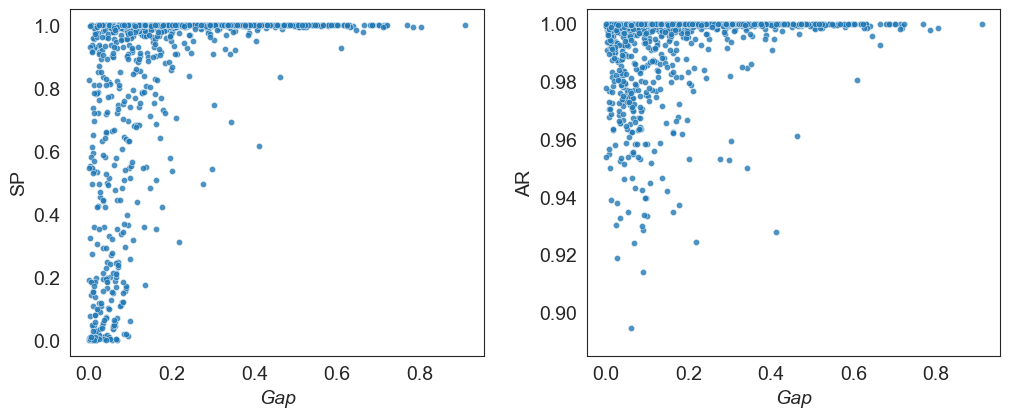

In [71]:
plot_sp_ar(df)

**Seleccionamos las peores instancias**

Número de simulaciones con AR < 0.99:' 223


<Axes: xlabel='ar', ylabel='Count'>

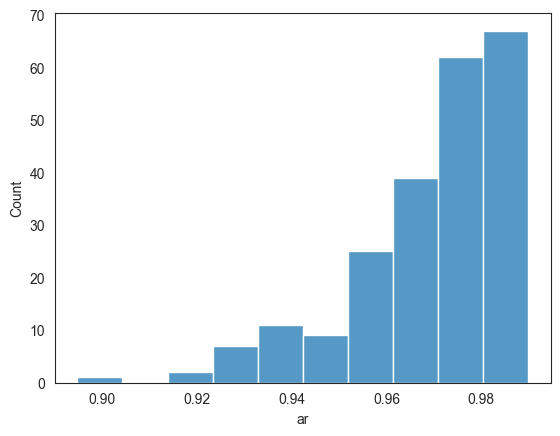

In [72]:
umbral = 0.99
print(f"Número de simulaciones con AR < {umbral}:' {len(df[df['ar'] < umbral])}")
sns.histplot(df[df['ar'] < umbral]['ar'], binwidth=0.01)

In [55]:
df2 = df[df['ar'] < 0.99]
print('Número de filas:', len(df2))
df2_v2 = df2.iloc[[10,15]]
df2.ar.mean()

Número de filas: 223


np.float64(0.9694495590940521)

In [88]:
semillas_optimizadas = df2.seed
bool_semillas_optimizadas = df.seed.isin(semillas_optimizadas)

# Optimización

## Defino los Drivings

Se han probado diferentes definiciones de drivings, pero los comentados en la memoria son los que mejor resultado han dado.

### Transición seno local

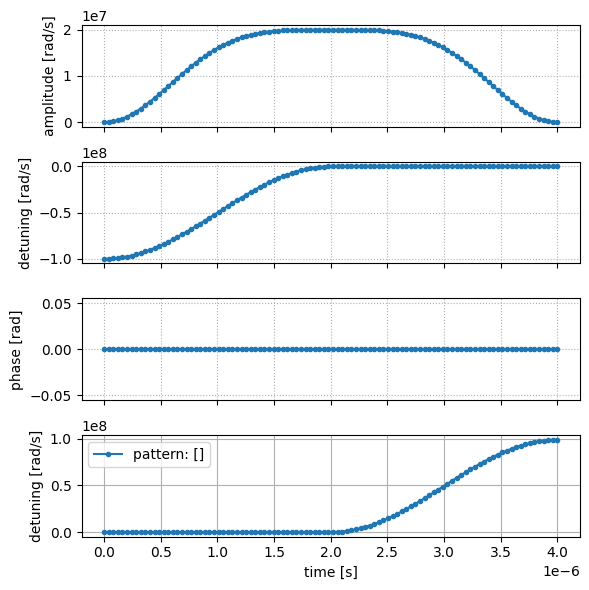

In [61]:
def Delta_local(t, t_max, Delta_local_max, a, b):
    # assert 0 <= a <= t_max
    # assert a/2 <= b <= t_max - a/2

    if t >= 0 and t < b - a/2:
        return 0
    elif t >= b - a/2 and t < b + a/2:
        return Delta_local_max/2 + Delta_local_max/2*np.sin(np.pi/a*(t - b))
    elif t >= b + a/2:
        return Delta_local_max

                
def Delta(t, t_max, Delta_max):
    if t < t_max/2:
        return -Delta_max -Delta_max*np.cos(np.pi*t/(t_max/2))
    else:
        return 0


def Drivings(t, Omega_max, Delta_max, Delta_local_max, og_weights, Delta_local_0):
    assert len(Delta_local_0) == 2
    
    t0 = 0
    time_max = t*1e-6
    Delta_local_0 = (Delta_local_0[0] * t, Delta_local_0[1] * t)
    
    time = np.linspace(t0, time_max, 100)
    ##MAXIMOS AQUILA
    #Omega_max = 15 *1e6  #RAD/S
    #Delta_max =  7.5 * 1e6 #RAD/S
    #Delta_local_max = 17 *1e6 #BEST
    
    omega_array = Omega_max*(np.sin((np.pi/2)*np.sin(np.pi*time/time_max)))**2
    delta_array = [Delta(t, time_max, Delta_max) for t in time]
    delta_local_array = [Delta_local(t, time_max, Delta_local_max, Delta_local_0[0]*1e-6, Delta_local_0[1]*1e-6) for t in time]
    #
    #-----------------------------
    phi_array = np.zeros_like(omega_array)
    
    
    omega = TimeSeries()
    
    for t_step, val in zip(time, omega_array):
        omega.put(t_step, val)
    
    
    global_detuning = TimeSeries()
    
    for t_step, val in zip(time, delta_array):
        global_detuning.put(t_step, val)
    
    phi = TimeSeries()

    for t_step, val in zip(time, phi_array):
        phi.put(t_step, val)
    

    # Asegurarse de que no hay elementos `None` en los valores de los drivings
    if any(v is None for v in delta_local_array):
        print(Delta_local_0)
        raise ValueError("`values` contiene elementos `None` no permitidos en delta_local_array.")
    if any(v is None for v in omega.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en omega.")
    if any(v is None for v in phi.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en phi.")
    if any(v is None for v in global_detuning.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en global_detuning.")
    
    
    # Defino los drivings global y local
    drive = DrivingField(amplitude=omega,
                         phase=phi,
                         detuning=global_detuning)
    
    local_detuning_drive = LocalDetuning.from_lists(times=time,
                                                        values=delta_local_array,
                                                        pattern=og_weights)
    

    return drive, local_detuning_drive, delta_local_array, time

# Muestro un driving ejemplo
time_max = 4
Omega_max = 20 *1e6  #RAD/S
Delta_max =  50 * 1e6 #RAD/S
Delta_local_max = 9.9007768e7 #BEST con un tercio funciona mejor
Delta_local_0 = (2/4, 3/4) # 0 < a < time_max,    a/2 < b < time_max - a/2

og_weights = []
drive, local_detuning_drive, delta_local_array, time = Drivings(time_max, Omega_max, Delta_max, Delta_local_max, og_weights, Delta_local_0)

show_drive_and_local_detuning(drive , local_detuning_drive)


### Transición seno local y global

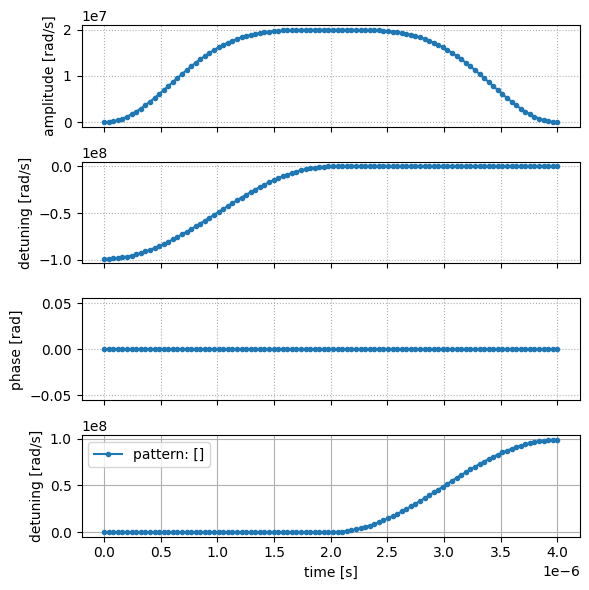

In [60]:
def Delta_local2(t, t_max, Delta_local_max, a, b):
    # assert 0 <= a <= t_max
    # assert a/2 <= b <= t_max - a/2

    if t >= 0 and t < b - a/2:
        return 0
    elif t >= b - a/2 and t < b + a/2:
        return Delta_local_max/2 + Delta_local_max/2*np.sin(np.pi/a*(t - b))
    elif t >= b + a/2:
        return Delta_local_max

                
def Delta2(t, t_max, Delta_max, a, b):
    if t >= 0 and t < b - a/2:
        return -Delta_local_max
    elif t >= b - a/2 and t < b + a/2:
        return -Delta_local_max/2 + Delta_local_max/2*np.sin(np.pi/a*(t - b))
    elif t >= b + a/2:
        return 0


def Drivings2(t, Omega_max, Delta_max, Delta_local_max, og_weights, Delta_0):
    t0 = 0
    time_max = t*1e-6
    
    # Parámetros del Delta global
    Delta_global_0 = (Delta_0[0] * t, Delta_0[1] * t)

    # Parámetros del Delta local
    Delta_local_0 = (Delta_0[2] * t, Delta_0[3] * t)

    
    
    time = np.linspace(t0, time_max, 100)
    ##MAXIMOS AQUILA
    #Omega_max = 15 *1e6  #RAD/S
    #Delta_max =  7.5 * 1e6 #RAD/S
    #Delta_local_max = 17 *1e6 #BEST
    
    omega_array = Omega_max*(np.sin((np.pi/2)*np.sin(np.pi*time/time_max)))**2
    delta_array = [Delta2(t, time_max, Delta_max, Delta_global_0[0]*1e-6, Delta_global_0[1]*1e-6) for t in time]
    delta_local_array = [Delta_local2(t, time_max, Delta_local_max, Delta_local_0[0]*1e-6, Delta_local_0[1]*1e-6) for t in time]
    #
    #-----------------------------
    phi_array = np.zeros_like(omega_array)
    
    
    omega = TimeSeries()
    
    for t_step, val in zip(time, omega_array):
        omega.put(t_step, val)
    
    
    global_detuning = TimeSeries()
    
    for t_step, val in zip(time, delta_array):
        global_detuning.put(t_step, val)
    
    phi = TimeSeries()

    for t_step, val in zip(time, phi_array):
        phi.put(t_step, val)
    

    # Asegurarse de que no hay elementos `None` en los valores de los drivings
    if any(v is None for v in delta_local_array):
        print(Delta_local_0)
        raise ValueError("`values` contiene elementos `None` no permitidos en delta_local_array.")
    if any(v is None for v in omega.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en omega.")
    if any(v is None for v in phi.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en phi.")
    if any(v is None for v in global_detuning.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en global_detuning.")
    
    
    # Defino los drivings global y local
    drive = DrivingField(amplitude=omega,
                         phase=phi,
                         detuning=global_detuning)
    
    local_detuning_drive = LocalDetuning.from_lists(times=time,
                                                        values=delta_local_array,
                                                        pattern=og_weights)
    

    return drive, local_detuning_drive, delta_local_array, time

# Muestro un driving ejemplo
time_max = 4
Omega_max = 20 *1e6  #RAD/S
Delta_max =  50 * 1e6 #RAD/S
Delta_local_max = 9.9007768e7 #BEST con un tercio funciona mejor
Delta_global_0 = (time_max/2, 1*time_max/4) # 0 < a < time_max,    a/2 < b < time_max - a/2
Delta_local_0 = (time_max/2, 3*time_max/4) # 0 < a < time_max,    a/2 < b < time_max - a/2
Delta_0 = (1/2, 1/4, 1/2, 3/4)

og_weights = []
drive, local_detuning_drive, delta_local_array, time = Drivings2(time_max, Omega_max, Delta_max, Delta_local_max, og_weights, Delta_0)

show_drive_and_local_detuning(drive , local_detuning_drive)


### Transición seno local y global completo

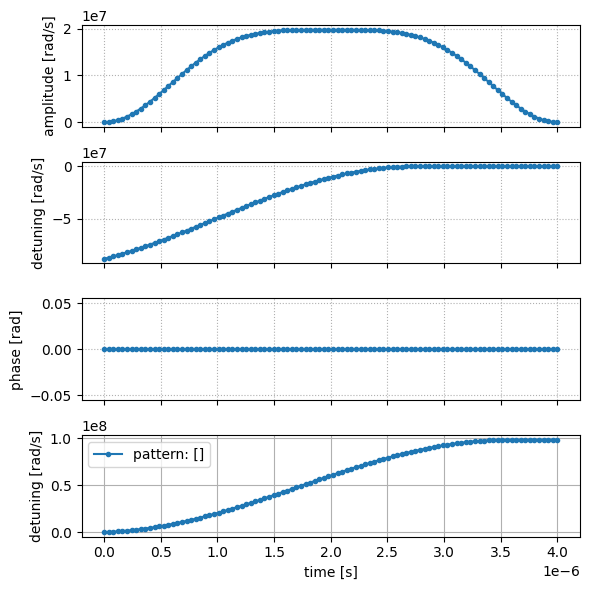

In [62]:
def Delta_local3(t, t_max, Delta_local_max, a, b):
    # assert 0 <= a <= t_max
    # assert a/2 <= b <= t_max - a/2

    if t >= 0 and t < b - a/2:
        return 0
    elif t >= b - a/2 and t < b + a/2:
        return Delta_local_max/2 + Delta_local_max/2*np.sin(np.pi/a*(t - b))
    elif t >= b + a/2:
        return Delta_local_max

                
def Delta3(t, t_max, Delta_max, a, b):
    if t >= 0 and t < b - a/2:
        return -Delta_local_max
    elif t >= b - a/2 and t < b + a/2:
        return -Delta_local_max/2 + Delta_local_max/2*np.sin(np.pi/a*(t - b))
    elif t >= b + a/2:
        return 0


def Drivings3(t, og_weights, Delta_0):
    t0 = 0
    time_max = t*1e-6
    
    # Parámetros del Delta global
    Delta_global_0 = (Delta_0[0] * t, Delta_0[1] * t)

    # Parámetros del Delta local
    Delta_local_0 = (Delta_0[2] * t, Delta_0[3] * t)

    Omega_max = Delta_0[4] * 20 * 1e6
    Delta_max = Delta_0[5] * 50 * 1e6
    Delta_local_max = Delta_0[6] * 9.9007768e7
    
    
    time = np.linspace(t0, time_max, 100)
    
    omega_array = Omega_max*(np.sin((np.pi/2)*np.sin(np.pi*time/time_max)))**2
    delta_array = [Delta3(t, time_max, Delta_max, Delta_global_0[0]*1e-6, Delta_global_0[1]*1e-6) for t in time]
    delta_local_array = [Delta_local3(t, time_max, Delta_local_max, Delta_local_0[0]*1e-6, Delta_local_0[1]*1e-6) for t in time]
    #
    #-----------------------------
    phi_array = np.zeros_like(omega_array)
    
    
    omega = TimeSeries()
    
    for t_step, val in zip(time, omega_array):
        omega.put(t_step, val)
    
    
    global_detuning = TimeSeries()
    
    for t_step, val in zip(time, delta_array):
        global_detuning.put(t_step, val)
    
    phi = TimeSeries()

    for t_step, val in zip(time, phi_array):
        phi.put(t_step, val)
    

    # Asegurarse de que no hay elementos `None` en los valores de los drivings
    if any(v is None for v in delta_local_array):
        print(Delta_local_0)
        raise ValueError("`values` contiene elementos `None` no permitidos en delta_local_array.")
    if any(v is None for v in omega.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en omega.")
    if any(v is None for v in phi.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en phi.")
    if any(v is None for v in global_detuning.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en global_detuning.")
    
    
    # Defino los drivings global y local
    drive = DrivingField(amplitude=omega,
                         phase=phi,
                         detuning=global_detuning)
    
    local_detuning_drive = LocalDetuning.from_lists(times=time,
                                                        values=delta_local_array,
                                                        pattern=og_weights)
    

    return drive, local_detuning_drive, delta_local_array, time

# Muestro un driving ejemplo
time_max = 4
Omega_max = 20 *1e6  #RAD/S
Delta_max =  50 * 1e6 #RAD/S
Delta_local_max = 9.9007768e7 #BEST con un tercio funciona mejor
Delta_global_0 = (time_max/2, 1*time_max/4) # 0 < a < time_max,    a/2 < b < time_max - a/2
Delta_local_0 = (time_max/2, 3*time_max/4) # 0 < a < time_max,    a/2 < b < time_max - a/2
Delta_0 = (0.8652355126639384, 0.24819216712308245, 0.9242566997749775, 0.43265458310415383, 0.9887876493633664, 0.5878671779937633, 0.9917998996635303)

og_weights = []
drive, local_detuning_drive, delta_local_array, time = Drivings3(time_max, og_weights, Delta_0)

show_drive_and_local_detuning(drive , local_detuning_drive)


### Transición interpolación lineal

[19801553.6, 33002589.333333332, 49503884.0]


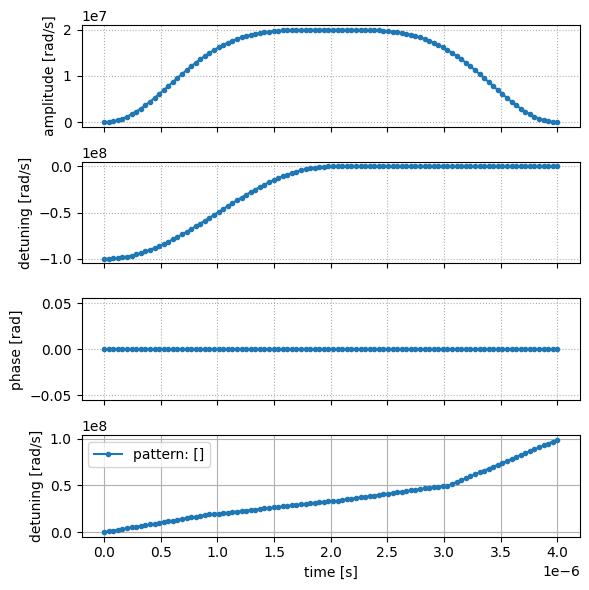

In [66]:
def trans_lineal(time, d_ini, d_fin):
    return [float(d_ini + (d_fin - d_ini)*(t - time[0])/(time[-1] - time[0])) for t in time]

def diving_trans_lineal(t, Omega_max, Delta_max, Delta_local_max, og_weights, Delta_0):
    n_puntos = len(Delta_0)
    Delta_0 = [d * Delta_local_max for d in Delta_0]
    print(Delta_0)

    t0 = 0
    time_max = t*1e-6

    # Generar el vector temporal
    time = np.linspace(t0, time_max, 100)
    
    
    omega_array = Omega_max*(np.sin((np.pi/2)*np.sin(np.pi*time/time_max)))**2
    phi_array = np.zeros_like(omega_array)
    delta_array = [Delta(t, time_max, Delta_max) for t in time]

    # Detuning local
    delta_local_array = []
    dt, resto = len(time)//(n_puntos + 1), len(time)%(n_puntos + 1)
    delta_local_array.append(trans_lineal(time[0:dt], 0, Delta_0[0]))

    for i in range(1, n_puntos):

        delta_local_array.append(trans_lineal(time[dt*i:dt*(i+1)], Delta_0[i-1], Delta_0[i]))
    i += 1

    
    delta_local_array.append(trans_lineal(time[dt*i:], Delta_0[i-1], Delta_local_max))

    delta_local_array = [elemento for sublista in delta_local_array for elemento in sublista]


    omega = TimeSeries()
    for t_step, val in zip(time, omega_array):
        omega.put(t_step, val)
    
    
    global_detuning = TimeSeries()    
    for t_step, val in zip(time, delta_array):
        global_detuning.put(t_step, val)
    
    phi = TimeSeries()
    for t_step, val in zip(time, phi_array):
        phi.put(t_step, val)
    

    # Asegurarse de que no hay elementos `None` en los valores de los drivings
    if any(v is None for v in delta_local_array):
        print(Delta_local_0)
        raise ValueError("`values` contiene elementos `None` no permitidos en delta_local_array.")
    if any(v is None for v in omega.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en omega.")
    if any(v is None for v in phi.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en phi.")
    if any(v is None for v in global_detuning.values()):
        raise ValueError("`values` contiene elementos `None` no permitidos en global_detuning.")
    
    
    # Defino los drivings global y local
    drive = DrivingField(amplitude=omega,
                         phase=phi,
                         detuning=global_detuning)
    
    local_detuning_drive = LocalDetuning.from_lists(times=time,
                                                        values=delta_local_array,
                                                        pattern=og_weights)
    

    return drive, local_detuning_drive, delta_local_array, time

# Muestro un driving ejemplo
time_max = 4
Omega_max = 20 *1e6  #RAD/S
Delta_max =  50 * 1e6 #RAD/S
Delta_local_max = 9.9007768e7 #BEST con un tercio funciona mejor
Delta_global_0 = (time_max/2, 1*time_max/4) # 0 < a < time_max,    a/2 < b < time_max - a/2
Delta_local_0 = (time_max/2, 3*time_max/4) # 0 < a < time_max,    a/2 < b < time_max - a/2
Delta_0 = [1/5, 1/3, 1/2]

og_weights = []
drive, local_detuning_drive, delta_local_array, time = diving_trans_lineal(time_max, Omega_max, Delta_max, Delta_local_max, og_weights, Delta_0)
show_drive_and_local_detuning(drive , local_detuning_drive)


## Defino función de coste

Defino una función de coste, donde para dado una disposición de atomos, unos pesos y los drivings, me devuelve la densidad de ridberg, además, del registro de la medida y el driving local utilizado.

In [63]:
from typing import Callable
def loss(df, Delta_list: list, drivings: Callable, show_drive=False):
    # Los drivings son los mismos para todos los grafos menos por los esos
    # Defino los drivings
    pattern = []
    drive, local_detuning_drive, delta_local_array, time = drivings(time_max, Omega_max, Delta_max,
                                                                    Delta_local_max, pattern, Delta_list)

    ar_list = []
    
    # Para cada grafo en el dataframe ejecutamos la simulación
    for i in range(len(df)):
        # Obtengo el grafo y el AtomArrangement
        n_nodos = df.iloc[i]['n_nodos'].astype(np.int64)
        atoms_w = df.iloc[i]['atoms_w'].astype(np.int64)
        atoms_l = df.iloc[i]['atoms_l'].astype(np.int64)
        seed = df.iloc[i]['seed'].astype(np.int64)

        np.random.seed(seed)
        graph, atoms = Graph_gen(n_nodos, atoms_w, atoms_l, scale)

        pattern = [float(i) for i in nx.get_node_attributes(graph, 'weight').values()]
        
        # Defino los drivings
        local_detuning_drive = LocalDetuning.from_lists(times=time,
                                                        values=delta_local_array,
                                                        pattern=pattern)

        # Defino el hamiltoniano
        program = AnalogHamiltonianSimulation(hamiltonian=drive + local_detuning_drive,
                                            register=atoms)
        device = LocalSimulator("braket_ahs")
        if show_drive:
            show_drive_and_local_detuning(drive , local_detuning_drive)
        # Ejecutamos la simulacion
        result = simulator.run(program, steps=steps, shots=shots, blockade_radius=blockade_radius).result()
        counters = result.get_counts()
        gr_list = list(counters.keys())
        Counts = list(counters.values())
            
        # Calculamos la energía de cada bitstring obtenido en la simulacion
        counters = pd.DataFrame({'bitstring': gr_list, 'Counts': Counts})
        counters['e_H'] = [C_from_gr(gr, pattern, graph.edges()) for gr in counters['bitstring']]
        counters = counters.sort_values(by='Counts', ascending=False)

        # Calculo la solución de gurobi
        optimal_value, opt_solutions = Gurobi_solver(graph)
        gur_solution = Gurobi_to_gr(opt_solutions, len(graph.nodes()))

        # Calculo el AR
        ar_list.append(float(sum(counters['e_H'] * counters['Counts']) / shots / optimal_value))
    
    ar_media = np.mean(ar_list)

    if show_drive:
        show_drive_and_local_detuning(drive , local_detuning_drive)
    
    return -ar_media

## Optimización de hiperpárametros

Buscamos los drivings que minimicen la media de la energía. De momento ahy 3 opciones de drivings.
- **Drivings**: Optimiza el driving local, que se define como una transición seno desde el valor mínimo ahsta el máximo
- **Divings2**: Optimiza el driving local y global, que se definen como una transición seno desde el valor mínimo ahsta el máximo
- **diving_trans_lineal**: optimiza el driving local, que se define como una transición lineal a otrozos entre el valor mínimo hasta el máximo. Se puede especificar el número de puntos a optimizar variando el número de puntos iniciales en `driving_0_options` (También habrá que modificar el `bounds`)

In [67]:
# Diccionario con los parámetros iniciales para cada parametrización de los drivings
driving_0_dic = [(2/4, 3/4),                  # Parámetros inciales para Drivings
                     (4/4, 2/4, 4/4, 2/4),    # Parámetros inciales para Drivings2
                     (1/4, 2/4, 3/4)]         # Parámetros inciales para diving_trans_lineal

# Diccionario con los bounds para cada parametrización de los drivings
bounds_dic = [((0, 1), (0, 1)),               # Bounds para Drivings
          ((0, 1), (0, 1), (0, 1), (0, 1)),   # Bounds para Drivings2
          ((0, 1), (0, 1), (0, 1))]           # Bounds para diving_trans_lineal

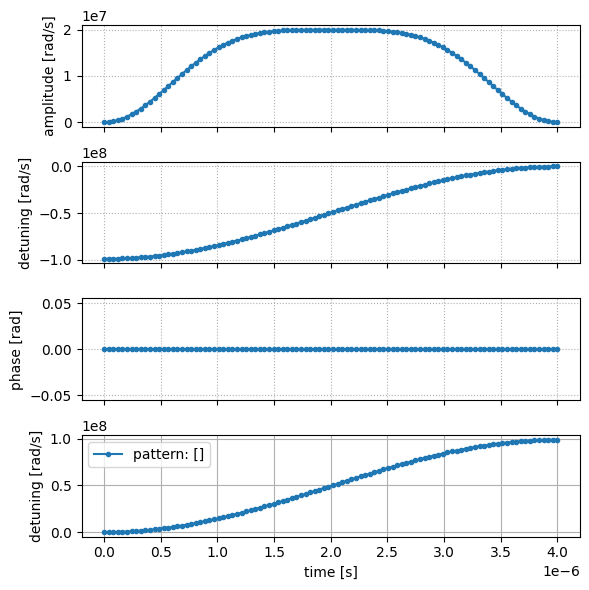

In [68]:
# Opciones de drivings para la optimización
driving_options = [Drivings, Drivings2, diving_trans_lineal]

# Decido la función de Driving que quiero utilizar
F_drivings = Drivings2

Delta_0 = driving_0_dic[driving_options.index(F_drivings)]
bounds = bounds_dic[driving_options.index(F_drivings)]

# Mostramos los drivings iniciales
pattern = []
drive, local_detuning_drive, delta_local_array, time = F_drivings(time_max, Omega_max, Delta_max, Delta_local_max, pattern, Delta_0)
show_drive_and_local_detuning(drive, local_detuning_drive)

In [423]:
# Calculo la energía inicial
initial_ar = loss(df2, Delta_0, F_drivings, show_drive=False)
print(f"Initial mean ar: {-initial_ar}")
print(f'Initial values: {Delta_0}')

Initial mean ar: 0.9520951069680125
Initial values: (1.0, 0.5, 1.0, 0.5)


In [424]:
# Busco los parámetros óptimos
optresult = optimize.minimize(lambda x: loss(df2, x, F_drivings),
                              Delta_0, method='COBYLA', options={'maxiter': 100}, bounds=bounds)

In [425]:
# Guardo el registro optimo
final_ar = loss(df2, optresult.x, F_drivings, show_drive=False)
print(optresult.message)
print(f"Final mean ar: {-final_ar}")
print(f"Final values: {optresult.x}")

Optimization terminated successfully.
Final mean ar: 0.9811835639035685
Final values: [8.09710347e-01 8.06375456e-06 8.05691002e-01 5.03259390e-01]


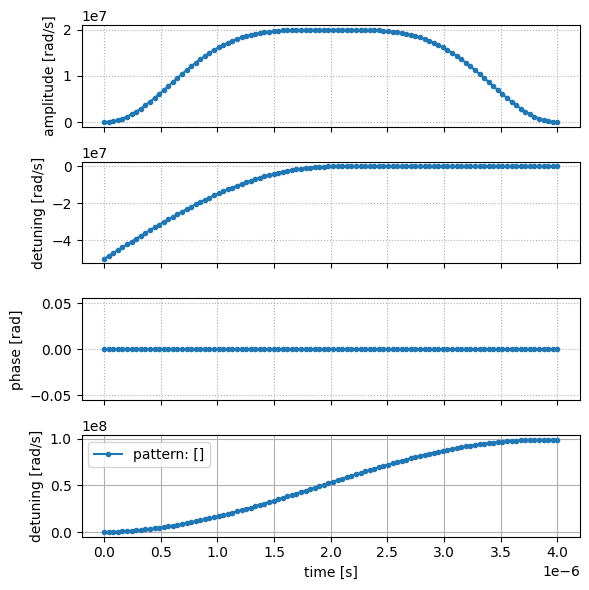

In [ ]:
# Mostramos los drivings finales
pattern = []
drive, local_detuning_drive, delta_local_array, time = F_drivings(time_max, Omega_max, Delta_max, Delta_local_max, pattern, optresult.x)
show_drive_and_local_detuning(drive, local_detuning_drive)

# Clasifiación de los 223 grafos con los nuevos drivings

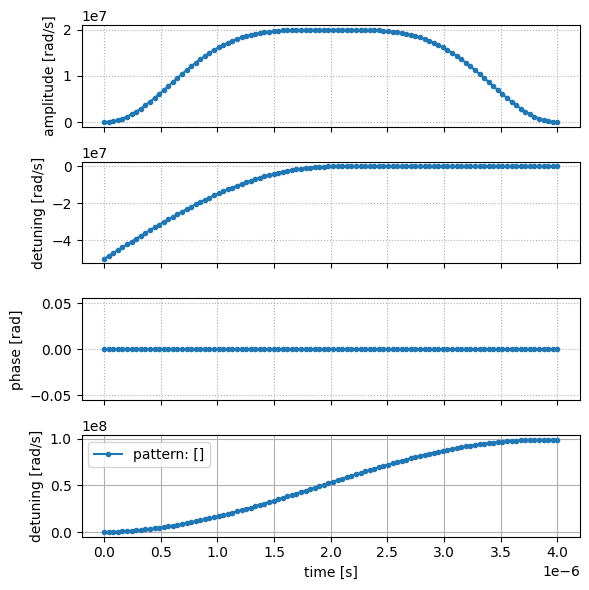

  0%|          | 0/223 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2025-11-24


C:\Users\aitoo\AppData\Local\Temp\ipykernel_3512\2727813596.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df3 = pd.concat([df3, pd.DataFrame([new_data])], ignore_index=True)
100%|██████████| 223/223 [14:02<00:00,  3.78s/it]


In [70]:
df3 = pd.DataFrame(columns=['n_nodos', 'atoms_w', 'atoms_l', 'seed', 'p_0', 'p_1', 'e_gap', 'e_0', 'e_1', 'succ', 'ar'])
# optresult = [1.0, 0.0034693044101895597, 0.9848532249044262, 0.4757343956087053]
drive, local_detuning_drive, delta_local_array, time = F_drivings(time_max, Omega_max, Delta_max, Delta_local_max, pattern, optresult.x)
show_drive_and_local_detuning(drive, local_detuning_drive)

# Calculamos la adiabaticidad para cada grafo
for i in tqdm(range(len(df2))):
    # Generamos el grafo
    n_nodos = df.loc[i, 'n_nodos']
    atoms_w = df.loc[i, 'atoms_w']
    atoms_l = df.loc[i, 'atoms_l']
    seed = df.loc[i, 'seed']
    np.random.seed(seed)
    graph, atoms = Graph_gen(n_nodos, atoms_w, atoms_l, scale)

    pattern = [float(i) for i in nx.get_node_attributes(graph, 'weight').values()]
    positions = np.array(list(nx.get_node_attributes(graph, 'pos').values()))

    # Defino los drivings
    local_detuning_drive = LocalDetuning.from_lists(times=time,
                                                    values=delta_local_array,
                                                    pattern=pattern)

    # Defino el hamiltoniano
    program = AnalogHamiltonianSimulation(hamiltonian=drive + local_detuning_drive,
                                        register=atoms)

    device = LocalSimulator("braket_ahs")

    # Ejecutamos la simulacion
    result = simulator.run(program, steps=steps, shots=shots, blockade_radius=blockade_radius).result()
    counters = result.get_counts()
    gr_list = list(counters.keys())
    Counts = list(counters.values())
        
    # Calculamos la energía de cada bitstring obtenido en la simulacion
    counters = pd.DataFrame({'bitstring': gr_list, 'Counts': Counts})
    counters['e_H'] = [C_from_gr(gr, pattern, graph.edges()) for gr in counters['bitstring']]
    counters = counters.sort_values(by='Counts', ascending=False)

    # Calculo la solución de gurobi y su SP
    optimal_value, opt_solutions = Gurobi_solver(graph)
    gur_solution = Gurobi_to_gr(opt_solutions, len(graph.nodes()))

    if gur_solution in list(counters['bitstring']):
        succ = float(list(counters[counters['bitstring'] == gur_solution]['Counts'])[0] / shots)
    else:
        succ = 0

    # Calculo el AR
    ar = float(sum(counters['e_H'] * counters['Counts']) / shots / optimal_value)

    # Calcular el espectro del grafo
    conf = get_blockade_configurations2(positions, 7.2e-6)
    espectro = pd.DataFrame(conf, columns=['bitstring'])
    espectro['energia'] = espectro['bitstring'].apply(lambda x: C_from_gr(x, pattern, graph.nodes()))
    espectro = espectro.sort_values('energia', ascending=True)

    e_gap = espectro['energia'].values[1] - espectro['energia'].values[0]
    e_min = espectro['energia'].values[0]


    #### Para calcular el e_gap tendría que calcular el espectro para cada grafo. -> la parte de gurobi la puedo quitar

    # Probabilidad del estado menos energético
    p_0 = list(counters['Counts'])[0]/shots
    # Probabilidad del segundo menos energético
    if len(counters) == 1:
        p_1 = 0
    else:
        p_1 = list(counters['Counts'])[1]/shots

    new_data = {'n_nodos': n_nodos, 'atoms_w': atoms_w, 'atoms_l': atoms_l, 'seed': seed, 'p_0': p_0, 'p_1': p_1, 'e_gap': e_gap, 'e_0': e_min, 'e_1': espectro['energia'].values[1], 'succ': succ, 'ar': ar}
    df3 = pd.concat([df3, pd.DataFrame([new_data])], ignore_index=True)

In [71]:
print(df3['succ'].mean())
print(df2['succ'].mean())

0.8652224215246636
0.4061986547085202


In [72]:
len(df3)

223

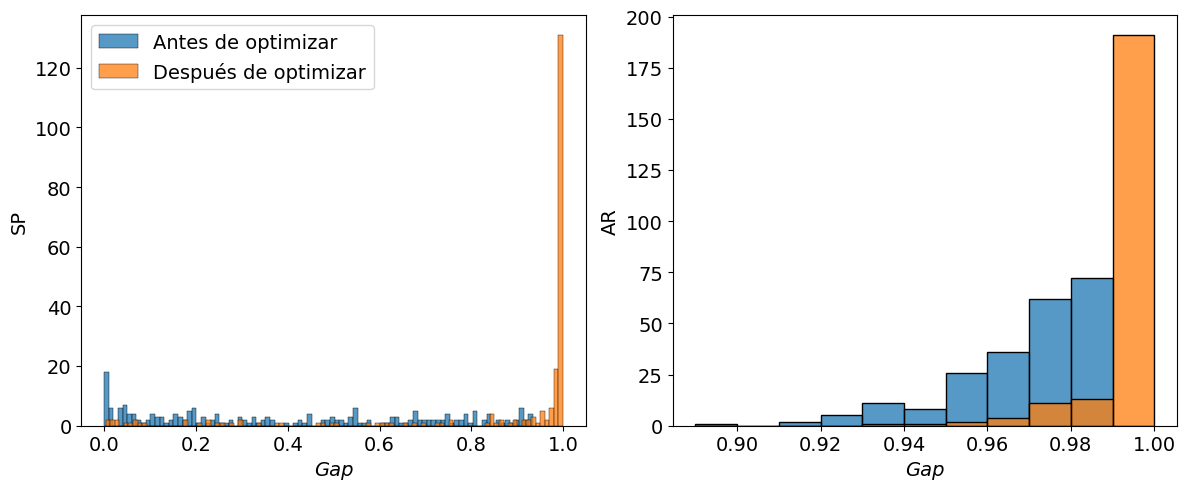

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Primer gráfico en el primer eje
sns.histplot(data=df2, x='ar', bins=np.linspace(0.89, 1, 12), ax=axes[1])
sns.histplot(data=df3, x='ar', bins=np.linspace(0.89, 1, 12), ax=axes[1])
axes[0].legend(['Inicial', 'Final'])

# Primer gráfico en el segundo eje
sns.histplot(data=df2, x='succ', binwidth=0.01, ax=axes[0])
sns.histplot(data=df3, x='succ', binwidth=0.01, ax=axes[0])
axes[0].legend(['Antes de optimizar', 'Después de optimizar'], fontsize=14)

plt.subplots_adjust(wspace=0.25) 
axes[0].set_xlabel('Gap', fontsize=14, style='italic')
axes[0].set_ylabel('SP', fontsize=14)
axes[0].tick_params(axis='both', labelsize=14)
# axes[0].set_ylim(-0.05, 1.05)
axes[1].set_xlabel('Gap', fontsize=14, style='italic')
axes[1].set_ylabel('AR', fontsize=14)
axes[1].tick_params(axis='both', labelsize=14)
# axes[1].set_ylim(0.885, 1.005)
# Ajustar layout

plt.tight_layout()
plt.show()

# Probar drivings nuevos en todo el dataset

Función:     Drivings2
Parámetros:  [1.0, 0.0034693044101895597, 0.9848532249044262, 0.4757343956087053]


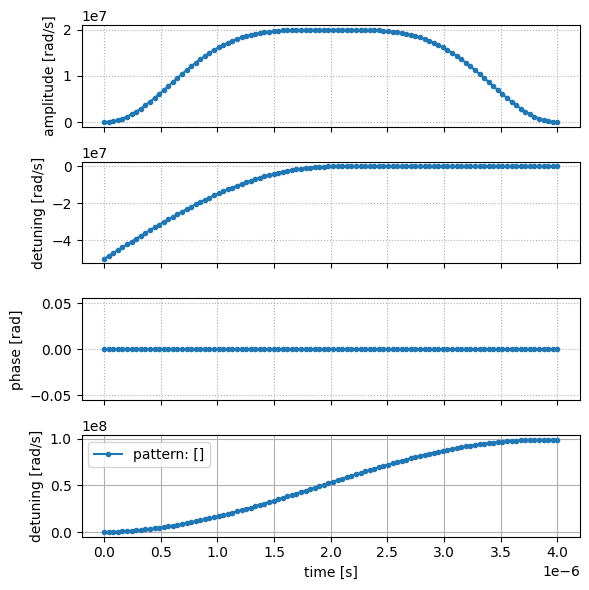

In [469]:
# Calcular drivins y detunings
ej_weights = np.array([])
Delta_0 = optresult.x
print('Función:    ', F_drivings.__name__)
print('Parámetros: ', Delta_0)
drive, local_detuning_drive, delta_local_array, time = F_drivings(time_max, Omega_max, Delta_max, Delta_local_max, ej_weights, optresult.x)
show_drive_and_local_detuning(drive, local_detuning_drive)

In [432]:
clasif = pd.DataFrame(columns=['n_nodos', 'atoms_w', 'atoms_l', 'seed', 'p_0', 'p_1', 'e_gap', 'e_0', 'e_1', 'succ', 'ar', 'curva', 'b', 'hp', 'hp_inv'])
        

print('Función:    ', F_drivings.__name__)
print('Parámetros: ', Delta_0)
print('Curvas:     ', curve_list)
print('Nº de ins.: ', len(df))

# Calculamos la adiabaticidad para cada grafo
for i in tqdm(range(len(df))):
    # Generamos el grafo
    n_nodos = df.loc[i, 'n_nodos']
    atoms_w = df.loc[i, 'atoms_w']
    atoms_l = df.loc[i, 'atoms_l']
    seed = df.loc[i, 'seed']
    np.random.seed(seed)
    G, register = Graph_gen(n_nodos, atoms_w, atoms_l, scale)

    # Guardamos propiedades relevantes del grafo
    og_weights = np.array(list(nx.get_node_attributes(G, 'weight').values()))
    positions = np.array(list(nx.get_node_attributes(G, 'pos').values()))

    ### Calculamos la solución optima con Gurobi
    optimal_value, opt_solutions = Gurobi_solver(G)

    ### ENERGÍA MEDIA EN SIMULACIÓN
    # Defino el detuning local
    local_detuning_drive = LocalDetuning.from_lists(times=time,
                                                        values=delta_local_array,
                                                        pattern=[float(round(peso, 4)) for peso in og_weights])

    # Defino el Hamiltoniano
    program = AnalogHamiltonianSimulation(hamiltonian=drive + local_detuning_drive, register=register)

    # Ejecutamos la simulacion
    result = simulator.run(program, steps=steps, shots=shots, blockade_radius=blockade_radius).result()
    counters = result.get_counts()
    gr_list = list(counters.keys())
    Counts = list(counters.values())
        
    # Calculamos la energía de cada bitstring obtenido en la simulacion
    counters = pd.DataFrame({'bitstring': gr_list, 'Counts': Counts})
    counters['e_H'] = [C_from_gr(gr, og_weights, G.edges()) for gr in counters['bitstring']]
    counters = counters.sort_values(by='Counts', ascending=False)

    # Calculo la solución de gurobi y su SP
    optimal_value, opt_solutions = Gurobi_solver(G)
    gur_solution = Gurobi_to_gr(opt_solutions, len(G.nodes()))

    if gur_solution in list(counters['bitstring']):
        succ = float(list(counters[counters['bitstring'] == gur_solution]['Counts'])[0] / shots)
    else:
        succ = 0

    # Calculo el AR
    ar = float(sum(counters['e_H'] * counters['Counts']) / shots / optimal_value)

    # Calcular el espectro del grafo
    conf = get_blockade_configurations2(positions, 7.2e-6)
    espectro = pd.DataFrame(conf, columns=['bitstring'])
    espectro['energia'] = espectro['bitstring'].apply(lambda x: C_from_gr(x, og_weights, G.nodes()))
    espectro = espectro.sort_values('energia', ascending=True)

    e_gap = espectro['energia'].values[1] - espectro['energia'].values[0]
    e_min = espectro['energia'].values[0]


    #### Para calcular el e_gap tendría que calcular el espectro para cada grafo. -> la parte de gurobi la puedo quitar

    # Probabilidad del estado menos energético
    p_0 = list(counters['Counts'])[0]/shots
    # Probabilidad del segundo menos energético
    if len(counters) == 1:
        p_1 = 0
    else:
        p_1 = list(counters['Counts'])[1]/shots


    for c in curve_list:
        for b in b_list:
            espectro['ponderacion'] = (espectro['energia'].apply(lambda x: gaussian(E=x, a=e_min, b=b, met=c)))
            hp = sum(espectro['ponderacion'].values)
            hp_inv = 1/hp
            new_data = {'n_nodos': n_nodos, 'atoms_w': atoms_w, 'atoms_l': atoms_l, 'seed': seed, 'p_0': p_0, 'p_1': p_1, 'e_gap': e_gap, 'e_0': e_min, 'e_1': espectro['energia'].values[1], 'succ': succ, 'ar': ar, 'curva': c, 'b': b, 'hp': hp, 'hp_inv': hp_inv}
            clasif = pd.concat([clasif, pd.DataFrame([new_data])], ignore_index=True)

# guardar dataframe

parametros = ''
for p in Delta_0:
    parametros += f'{p}_'

Función:     Drivings2
Parámetros:  [8.09710347e-01 8.06375456e-06 8.05691002e-01 5.03259390e-01]
Curvas:      ['linear', 'sqrt', 'square', 'cubic', 'cubic_root']
Nº de ins.:  1000


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\aitoo\AppData\Local\Temp\ipykernel_11860\795534915.py:85: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

100%|██████████| 1000/1000 [1:12:06<00:00,  4.33s/it]


In [ ]:
# clasif.to_csv(f'res_{F_drivings.__name__}_{parametros}1000.csv', index=False)

In [ ]:
clasif = pd.read_csv(f'../data/res_Drivings2_1.0_0.0034693044101895597_0.9848532249044262_0.4757343956087053_1000_clasificado.csv')

In [31]:
b_value = clasif['b'].unique()[12]
print(b_value)

0.1054308499733486


In [32]:
simul = clasif[(clasif['curva'] == 'cubic') & (clasif['b'] == b_value)]
simul.succ.mean()

np.float64(0.84557865)

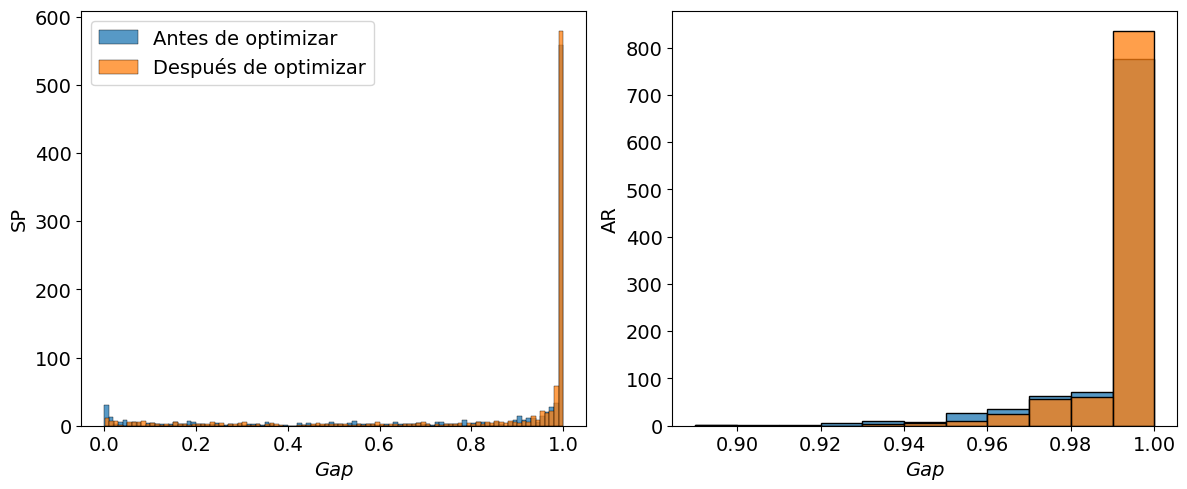

In [33]:
simul = clasif[(clasif['curva'] == 'linear') & (clasif['b'] == b_value)]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Primer gráfico en el primer eje
sns.histplot(data=df, x='succ', binwidth=0.01, ax=axes[0])
sns.histplot(data=simul, x='succ', binwidth=0.01, ax=axes[0])
axes[0].legend(['Inicial', 'Final'])

# Segundo gráfico en el segundo eje
sns.histplot(data=df, x='ar', bins=np.linspace(0.89, 1, 12), ax=axes[1])
sns.histplot(data=simul, x='ar', bins=np.linspace(0.89, 1, 12), ax=axes[1])
axes[0].legend(['Antes de optimizar', 'Después de optimizar'], fontsize=14)

plt.subplots_adjust(wspace=0.25) 
axes[0].set_xlabel('Gap', fontsize=14, style='italic')
axes[0].set_ylabel('SP', fontsize=14)
axes[0].tick_params(axis='both', labelsize=14)
# axes[0].set_ylim(-0.05, 1.05)
axes[1].set_xlabel('Gap', fontsize=14, style='italic')
axes[1].set_ylabel('AR', fontsize=14)
axes[1].tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

<Axes: xlabel='ar', ylabel='succ'>

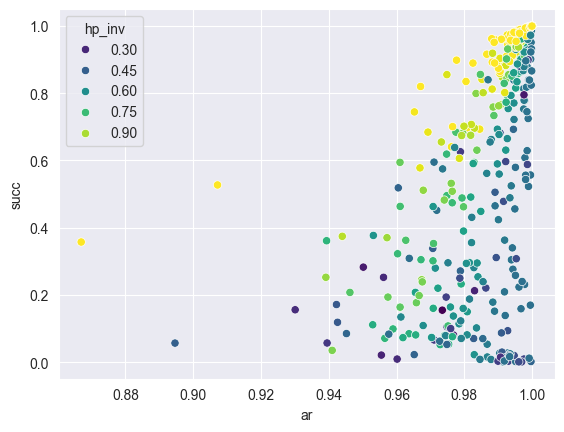

In [34]:
# Establecer un tema
sns.set_style("darkgrid")
sns.scatterplot(data=simul, x='ar', y='succ', hue='hp_inv', palette='viridis')

In [25]:
df_corr = clasif.groupby(['curva', 'b']).apply(lambda x: x['hp_inv'].corr(x['succ']), include_groups=False)
df_corr = df_corr.reset_index().rename(columns={0: 'correlation'})
df_corr


c:\Users\aitoo\anaconda3\envs\qml\lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\aitoo\anaconda3\envs\qml\lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,curva,b,correlation
0,cubic,0.001000,0.682720
1,cubic,0.002250,0.650613
2,cubic,0.004257,0.608668
3,cubic,0.007201,0.562689
4,cubic,0.011260,0.523099
...,...,...,...
145,square,0.671904,0.307303
146,square,0.745887,0.309300
147,square,0.825112,0.312403
148,square,0.909756,0.316088


In [26]:
# encontrar la fila con más correlacion
max_corr = df_corr['correlation'].max()
max_corr_row = df_corr[df_corr['correlation'] == max_corr]
max_corr_row

,curva,b,correlation
72,linear,0.105431,0.694616


In [27]:
#Nº de puntos ** Nº parámetros * T_iter / Nº jobs
24**4 * (3/600) / 6

276.48

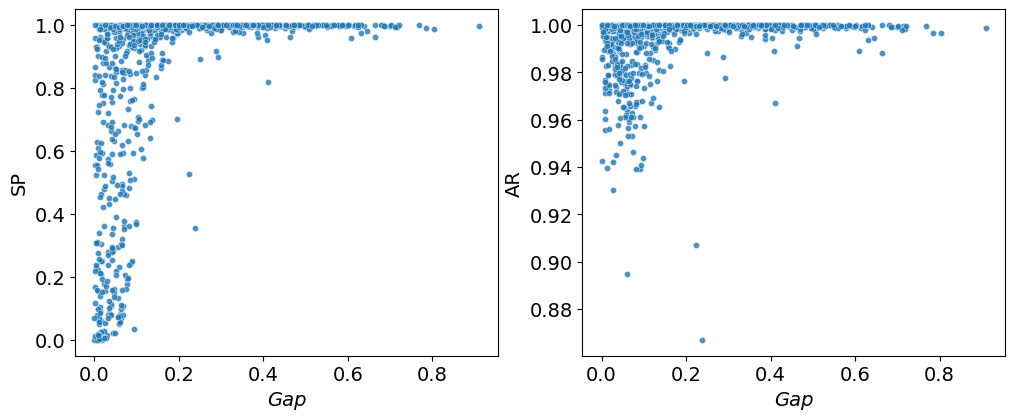

In [107]:
plot_sp_ar(simul)

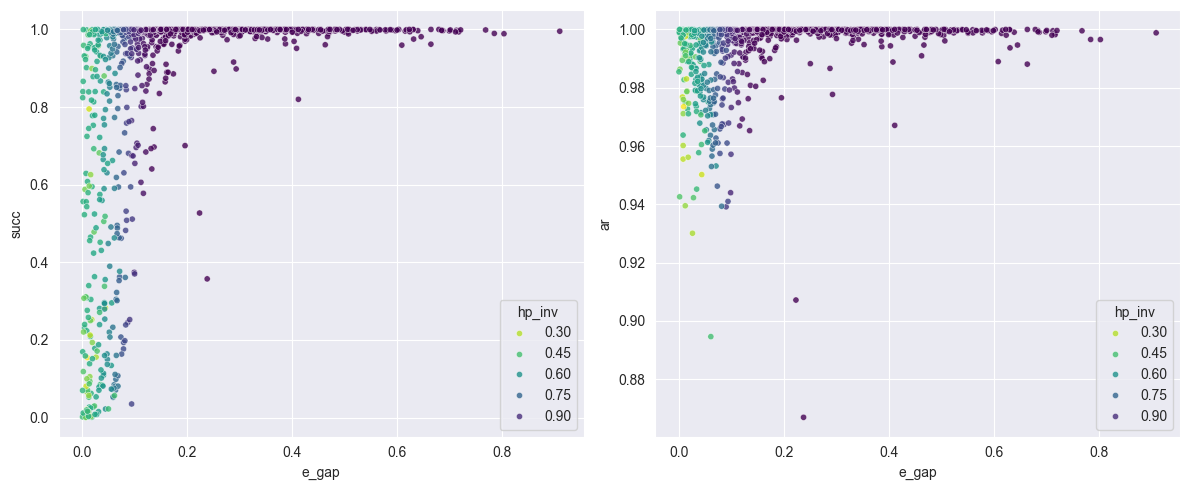

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Primer gráfico en el primer eje
sns.scatterplot(data=simul, x='e_gap', y='succ', hue='hp_inv', s=20, alpha=0.8, palette='viridis_r', ax=axes[0])

# Segundo gráfico en el segundo eje
sns.scatterplot(data=simul, x='e_gap', y='ar', hue='hp_inv', s=20, alpha=0.8, palette='viridis_r', ax=axes[1])
# Ajustar layout
plt.tight_layout()
plt.show()

In [ ]:

import ipywidgets as widgets
from ipywidgets import interact

# Lista de valores únicos de b y curva en clasif
b_values = clasif['b'].unique()
curva_values = clasif['curva'].unique()

# Función para actualizar el gráfico
def update_plot(umbral=0.1):
    # Filtrar el dataframe según el valor de b y la curva seleccionada
    simul2 = simul[(simul['e_gap'] < 0.1) & (simul['hp_inv'] < umbral)]


    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
    # Primer gráfico en el primer eje
    sns.scatterplot(data=simul2, x='e_gap', y='succ', hue='hp_inv', size=2, alpha=0.8, palette='viridis_r', ax=axes[0])
    axes[0].set_xlim([-0.005, 0.1])
    axes[0].set_ylim([-0.05, 1.05])
    # Segundo gráfico en el segundo eje
    sns.scatterplot(data=simul2, x='e_gap', y='ar', hue='hp_inv', size=2, alpha=0.8, palette='viridis_r', ax=axes[1])
    axes[1].set_xlim([-0.005, 0.1])
    axes[1].set_ylim([0.86, 1.01])
    
    # plt.title(f"Curva: {curva} | b = {b_values[b_index]:.3f}")
    plt.show()

# Crear widgets interactivos
# curva_dropdown = widgets.Dropdown(options=curva_values, value='cubic', description='Curva')
umbral_slider = widgets.FloatSlider(min=0.3, max=1, step=0.05, value=0.55, description='HP Inversa')
# b_slider = widgets.IntSlider(min=0, max=len(b_values) - 1, step=1, value=10, description='Índice b')

# Interfaz interactiva
interact(update_plot, umbral=umbral_slider);


# Comparar antes/después

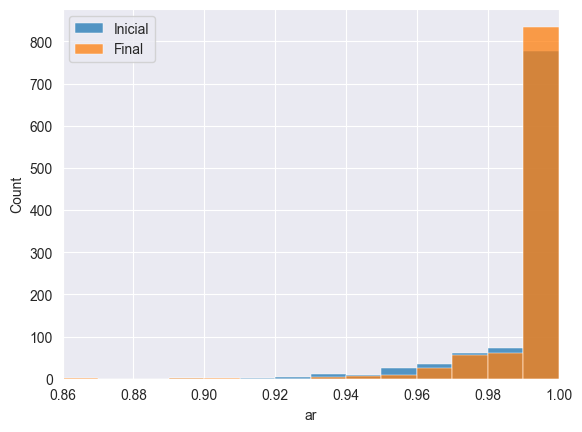

In [35]:
sns.histplot(data=df, x='ar', bins=np.arange(0, 1.01, 0.01), label='Inicial')
sns.histplot(data=simul, x='ar', bins=np.arange(0, 1.01, 0.01), label='Final')
plt.xlim([0.86, 1])
plt.legend()

In [36]:
df3 = clasif[(clasif['curva'] == 'linear') & (clasif['b'] == clasif['b'].unique()[0])].drop(columns=['curva', 'b', 'hp', 'hp_inv']).reset_index(drop=True)

# Comprobamos que se comparen los mismos grafos
if sum(df3['seed'] == df['seed']) != len(df3):
    print('El orden de las semillas no coincide -> no se puede hacer la comparación')

# Calcular diferencias entre antes y despues de optimizar
Dsucc = df3['succ'] - df['succ']
Dar = df3['ar'] - df['ar']

df_dif = pd.DataFrame({'seed': df['seed'], 'Dsucc': Dsucc, 'Dar': Dar, 'succ_ini': df['succ'], 'ar_ini': df['ar'], 'succ_fin': df3['succ'], 'ar_fin': df3['ar']})


print(f'mean(succ_fin - succ_ini): {Dsucc.mean()}')
print(f'mean(ar_fin - ar_ini):     {Dar.mean()}')

mean(succ_fin - succ_ini): 0.028541349999999997
mean(ar_fin - ar_ini):     0.0021096711326910977


Vemos que en general no ha habido una mejora. Puede parecer que no ha habido ningún cambio. En realidad, lo que sucede es que para algunos casos mejora y para otros empeora, de manera que los efectos se cancelan y la media queda en 0. 

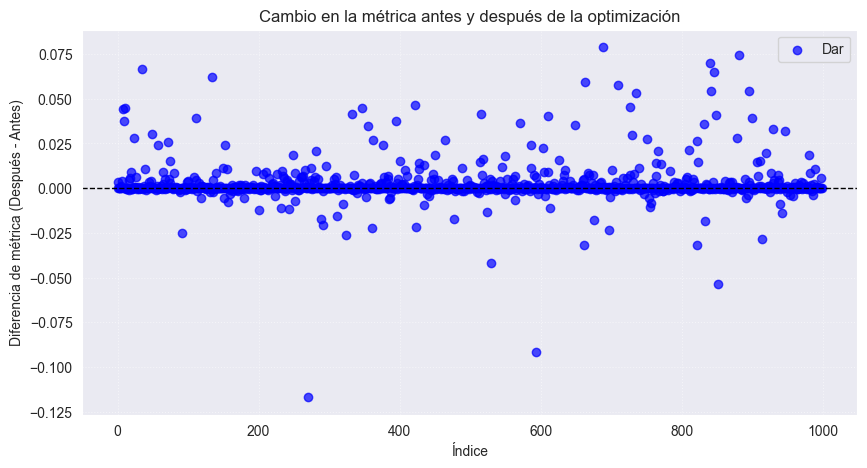

In [37]:
# Índices de los puntos
indices = np.arange(1000)
import matplotlib.pyplot as plt
# Crear la figura
plt.figure(figsize=(10, 5))

# Graficar las dos columnas como scatter plot
plt.scatter(indices, Dar, label='Dar', color='blue', alpha=0.7)
# plt.scatter(indices, Dar, label='ar', color='red', alpha=0.7)

# Línea de referencia en y = 0
plt.axhline(0, color='black', linestyle='dashed', linewidth=1)

# Etiquetas y leyenda
plt.xlabel("Índice")
plt.ylabel("Diferencia de métrica (Después - Antes)")
plt.title("Cambio en la métrica antes y después de la optimización")
plt.legend()
plt.grid(True, linestyle="dotted", alpha=0.5)

# Mostrar gráfico
plt.show()

In [85]:
len(bool_semillas_optimizadas)

223

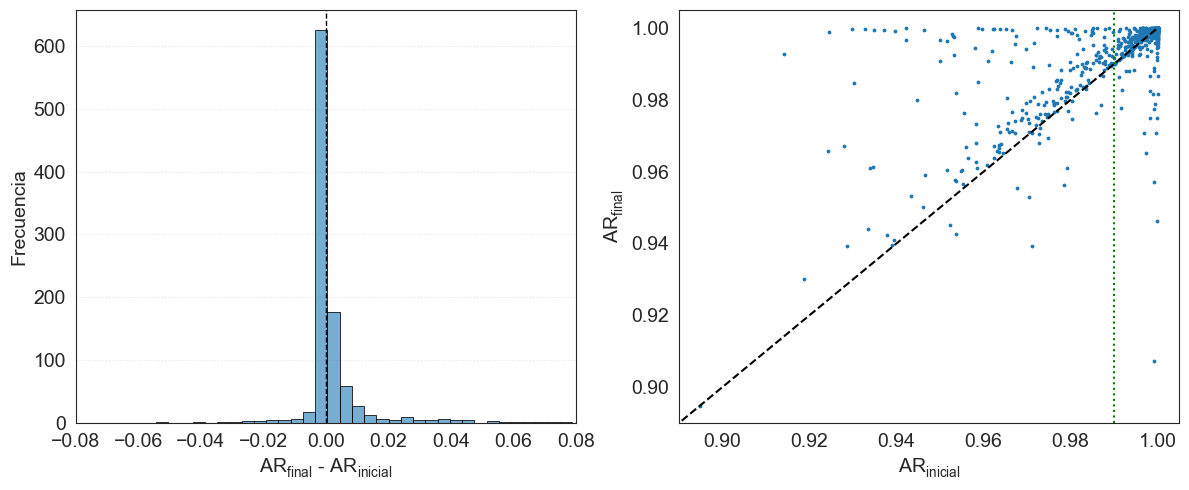

In [ ]:
colores = ['green' if b else 'blue' for b in bool_semillas_optimizadas]
# Crear figura principal
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
# Establecer estilo blanco de seaborn
sns.set_style("white")

x_min, x_max = -0.25, 0.25
y_max = 100
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
# Histograma principal
# sns.histplot(Dsucc, bins=30, alpha=0.6, color='blue', label='succ', edgecolor='black', binwidth=0.01, ax=axs[0])
sns.histplot(Dar, bins=50, alpha=0.6, edgecolor='black', ax=axs[0])

# Línea de referencia en x = 0
axs[0].axvline(0, color='black', linestyle='dashed', linewidth=1)

# Etiquetas y leyenda
axs[0].set_xlabel("AR$_{final}$ - AR$_{inicial}$", fontsize=14)
axs[0].set_ylabel("Frecuencia", fontsize=14)
# axs[0].set_title("Distribución de la mejora/empeoramiento tras la optimización")
# axs[0].legend(loc='upper left')
axs[0].grid(axis='y', linestyle="dotted", alpha=0.5)
axs[0].set_xlim(-0.08, 0.08)
axs[0].tick_params(axis='both', labelsize=14)

axs[1].scatter(df_dif['ar_ini'], df_dif['ar_fin'], alpha=1, s=3)
axs[1].plot([0, 1], [0, 1], linestyle='--', color='black')
axs[1].plot([0.99, 0.99], [0.89, 1.005], linestyle=':', color='green')
# axs[1].plot([0, 1-umbral], [umbral, 1], linestyle='-.', color='green')
# axs[1].plot([0, 1], [umbral, 1-umbral], linestyle='-.', color='green')
axs[1].set_xlabel('AR$_{inicial}$', fontsize=14)
axs[1].set_ylabel('AR$_{final}$', fontsize=14)
axs[1].set_xlim(0.89, 1.005)
axs[1].set_ylim(0.89, 1.005)
axs[1].tick_params(axis='both', labelsize=14)

# Ajustar los márgenes
plt.tight_layout()

# Mostrar la figura
plt.show()

**¿Hay alguna relación entre `ar` y `Dar`$\approx 0$?**

Vamos a ver cual es `Dar` para los casos donde `ar_ini`>0.99

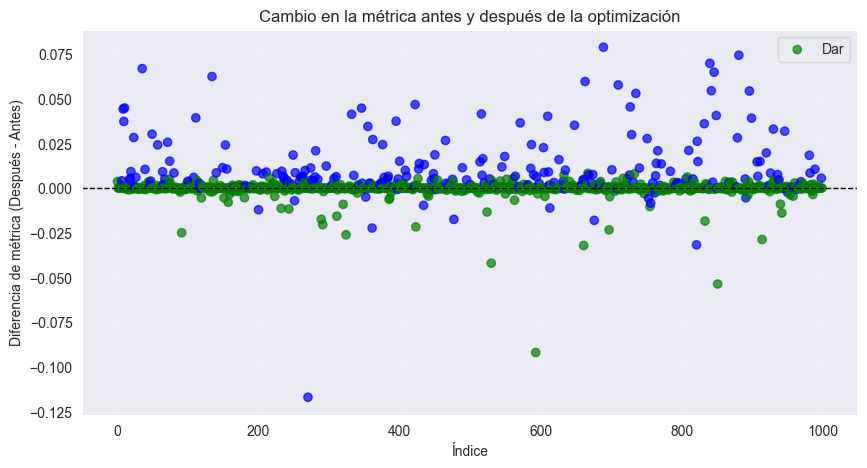

In [39]:
# Índices de los puntos
indices = np.arange(1000)
import matplotlib.pyplot as plt
# Crear la figura
plt.figure(figsize=(10, 5))

# Graficar las dos columnas como scatter plot
colors = np.where(df_dif['ar_ini'] >= 0.99, 'green', 'blue')
plt.scatter(data=df_dif, x=indices, y='Dar', label='Dar', color=colors, alpha=0.7)
# plt.scatter(indices, Dar, label='ar', color='red', alpha=0.7)

# Línea de referencia en y = 0
plt.axhline(0, color='black', linestyle='dashed', linewidth=1)

# Etiquetas y leyenda
plt.xlabel("Índice")
plt.ylabel("Diferencia de métrica (Después - Antes)")
plt.title("Cambio en la métrica antes y después de la optimización")
plt.legend()
plt.grid(True, linestyle="dotted", alpha=0.5)

# Mostrar gráfico
plt.show()

In [40]:
import plotly.express as px
import pandas as pd
import numpy as np

# Crear un DataFrame de ejemplo (reemplaza con tu propio DataFrame df_dif)
# df_dif = pd.DataFrame({'Dar': np.random.randn(1000), 'ar_ini': np.random.rand(1000), 'seed': np.random.randint(1, 1000, size=1000)})

# Generar los índices
indices = np.arange(1000)

# Añadir la columna 'indices' al DataFrame
df_dif['index'] = indices

# Asignar colores según 'ar_ini'
df_dif['color'] = np.where(df_dif['ar_ini'] >= 0.99, 'green', 'blue')

# Crear el gráfico interactivo
fig = px.scatter(df_dif, 
                 x='index', 
                 y='Dar', 
                 color='color',  # Colorear por la columna 'color'
                 labels={'index': 'Índice', 'Dar': 'Diferencia de métrica (Después - Antes)'},
                 hover_data={'color': False, 'index': False, 'Dar': False, 'seed': True, 'ar_ini': True, 'ar_fin': True},
                 color_discrete_map={'green': 'green', 'blue': 'blue'})  # Asignar colores específicos

# Agregar una línea horizontal en y=0
fig.add_hline(y=0, line_dash="dash", line_color="black")

# Eliminar la leyenda
fig.update_layout(showlegend=False)

# Mostrar la gráfica
fig.show()


Yo digo que si `abs(ar_fin - ar_ini) < 0.005` el resultado es constante.

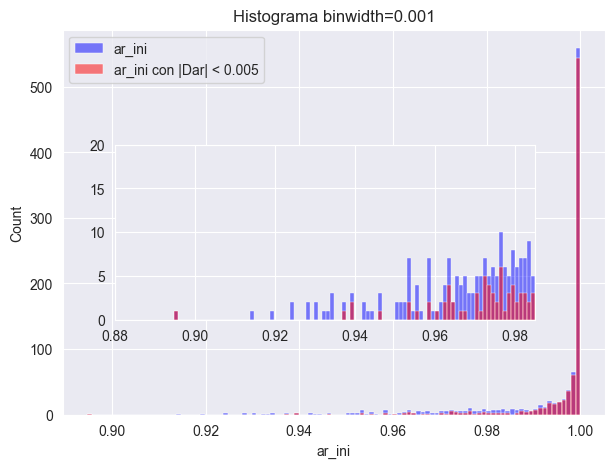

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Umbral
umbral = 0.005
binwidth = 0.001
# Crear la figura principal
fig, ax = plt.subplots(figsize=(7, 5))

# Graficar los dos histogramas
sns.histplot(df_dif['ar_ini'], alpha=0.5, color='blue', label='ar_ini', binwidth=binwidth, ax=ax)
sns.histplot(df_dif[df_dif['Dar'].abs() < umbral]['ar_ini'], alpha=0.5, color='red', label=f'ar_ini con |Dar| < {umbral}', binwidth=binwidth, ax=ax)

# Configurar etiquetas y leyenda
ax.set_xlabel('ar_ini')
ax.set_title(f'Histograma binwidth={binwidth}')
ax.legend()

# Crear el zoom en la región deseada
# Subgráfico para el zoom (usamos un lugar en la esquina superior derecha)
ax_inset = fig.add_axes([0.2, 0.3, 0.6, 0.35])  # [x, y, width, height]

# Graficar el histograma de la región de zoom
sns.histplot(df_dif['ar_ini'], alpha=0.5, color='blue', label='ar_ini', binwidth=binwidth, ax=ax_inset)
sns.histplot(df_dif[df_dif['Dar'].abs() < umbral]['ar_ini'], alpha=0.5, color='red', binwidth=binwidth, ax=ax_inset)

x_min, x_max = 0.88, 0.985
y_max = 20

# Configurar el zoom: límites
ax_inset.set_xlim(df_dif['ar_ini'].min(), df_dif['ar_ini'].max())  # O ajusta el rango de acuerdo con lo que necesites
ax_inset.set_ylim(0, y_max)  # Ajusta este valor dependiendo del rango de frecuencias de los histogramas

# Aplicar límites de zoom
ax_inset.set_xlim(x_min, x_max)
ax_inset.set_ylim(0, y_max)
ax_inset.axvline(0, color='black', linestyle='dashed', linewidth=1)

# Eliminar etiquetas y leyenda
ax_inset.set_xlabel("")
ax_inset.set_ylabel("")

# ---- Añadir un marco de líneas intermitentes en la zona de zoom ----
# ax.plot([x_min, x_max], [0, 0], 'k--', linewidth=1)  # Línea inferior
# ax.plot([x_min, x_max], [y_max, y_max], 'k--', linewidth=1)  # Línea superior
# ax.plot([x_min, x_min], [0, y_max], 'k--', linewidth=1)  # Línea izquierda
# ax.plot([x_max, x_max], [0, y_max], 'k--', linewidth=1)  # Línea derecha

# Mostrar la gráfica
plt.show()


Vemos que aquellos que en un principio daban un buen resultado son los que tienen |`Dar` < 0.005|. Es decir, al cambiar los drivings los valores de `ar` se mantienen casi constantes.